## 无标记数据的预训练

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib", 
		"numpy", 
		"tiktoken", 
		"torch",
		"tensorflow" # For OpenAI's pretrained weights
		]
for p in pkgs:
	print(f"{p} version: {version(p)}")

import torch
print(torch.__version__)
print(torch.cuda.is_available())

matplotlib version: 3.4.3
numpy version: 1.22.4
tiktoken version: 0.7.0
torch version: 2.4.1
tensorflow version: 2.13.1
2.4.1+cu121
True


### 5.1 Evaluating generative text models

#### 5.1.1 GPT生成文本

In [2]:
# 未有k v cache

import torch
from previous_chapters import GPTModel

GPT_CONFIG_124M = {
	"vocab_size": 50257,   # Vocabulary size
	"context_length": 256, # Shortened context length (orig: 1024)
	"emb_dim": 768,        # Embedding dimension
	"n_heads": 12,         # Number of attention heads
	"n_layers": 12,        # Number of layers
	"drop_rate": 0.1,      # Dropout rate
	"qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference	# 全局影响 可影响其他cell model.train()

In [3]:
import tiktoken
from previous_chapters import generate_text_simple

def text_to_token_ids(text, tokenizer):
	encoded = tokenizer.encode(text, allowed_special={"<|endoftext|"})
	encoded_tensor = torch.tensor(encoded).unsqueeze(0)
	return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
	flat = token_ids.squeeze(0)
	return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
	model=model,
	idx=text_to_token_ids(start_context, tokenizer),
	max_new_tokens=10,
	context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


#### 5.1.2 loss 交叉熵 perplexity

In [4]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
						[40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
						[1107,  588, 11311]]) #  " really like chocolate"]

In [5]:
# 通过model + softmax -> 概率
with torch.no_grad():
	logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print(probas.shape)
# 每个batch 中的 context_length 对应的50257为词表大小 其数值为对应该词的概率

torch.Size([2, 3, 50257])


- 将概率转回文本

In [6]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [7]:
print(f"Inputs batch 1: {token_ids_to_text(inputs[0], tokenizer)}")
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Inputs batch 1: every effort moves
Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [8]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
# target_probas_1 = probas[text_idx, :, targets[text_idx]]	# :会进行广播 导致结果为3*3 对每个词表概率都取了targets[text_idx]的三个值

print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

a = probas[text_idx]
print(a.shape)
b = a[[0,1,2]]
print(b.shape)
c = a[:]
print(c.shape)

Text 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])
torch.Size([3, 50257])
torch.Size([3, 50257])
torch.Size([3, 50257])


- 目标是令以上三值达到1

In [9]:
# 取对数
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

# 求平均
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])
tensor(-10.7940)


- 目标变为 令平均对数的值尽可能的大 上限为0

- *-1 变为尽可能小 


In [10]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- 交叉熵 流程

model+softmax求概率 $\rightarrow$ 取出目标的概率 $\rightarrow$ 取对数 $\rightarrow$ 求平均 $\rightarrow$ *-1

In [11]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [12]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [13]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


- 困惑度 exponential

- perplexity = exp(交叉熵)

In [14]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


#### 5.1.3 training validation set loss

In [15]:
import os
import urllib.request

file_path = "../ch02/the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
	with urllib.request.urlopen(url) as response:
		text_data = response.read().decode('utf-8')
	with open(file_path, "w", encoding="utf-8") as file:
		file.write(text_data)
else:
	with open(file_path, "r", encoding="utf-8") as file:
		text_data = file.read()

In [16]:
# First 99 characters
print(text_data[:99])
# Last 99 characters
print(text_data[-99:])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 
it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [17]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [18]:
from previous_chapters import create_dataloader_v1

train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(123)           # 设置CPU随机种子
torch.cuda.manual_seed(123)      # 设置当前GPU随机种子
torch.cuda.manual_seed_all(123)  # 设置所有GPU随机种子（多卡时）

train_loader = create_dataloader_v1(
	train_data,
	batch_size=2,
	max_length=GPT_CONFIG_124M["context_length"],
	stride=GPT_CONFIG_124M["context_length"],
	drop_last=True,
	shuffle=True,
	num_workers=0
)

val_loader = create_dataloader_v1(
	val_data,
	batch_size=2,
	max_length=GPT_CONFIG_124M["context_length"],
	stride=GPT_CONFIG_124M["context_length"],
	drop_last=False,
	shuffle=False,
	num_workers=0
)

In [19]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
	print("Not enough tokens for the training loader. "
		  "Try to lower the `GPT_CONFIG_124M['context_length']` or "
		  "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
	print("Not enough tokens for the validation loader. "
		  "Try to lower the `GPT_CONFIG_124M['context_length']` or "
		  "decrease the `training_ratio`")

In [20]:
print("Train loader:")
for x, y in train_loader:
	print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
	print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [21]:
train_tokens = 0
for input_batch, target_batch in train_loader:
	train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
	val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [22]:
def calc_loss_batch(input_batch, target_batch, model, device):
	"""
	计算给定批次的交叉熵
	"""
	input_batch, target_batch = input_batch.to(device), target_batch.to(device)
	logits = model(input_batch)
	loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
	return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
	total_loss=0.
	if len(data_loader) == 0:
		return float("nan")
	
	if num_batches is None:
		num_batches = len(data_loader)
	else:	# 防止batch的量比所有数量都多
		num_batches = min(num_batches, len(data_loader))
	
	for i, (input_batch, target_batch) in enumerate(data_loader):
		if i >= num_batches:
			break

		loss = calc_loss_batch(input_batch, target_batch, model, device)
		total_loss += loss.item()

	return total_loss / num_batches

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

with torch.no_grad():
	train_loss = calc_loss_loader(train_loader, model, device)
	val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758273654514
Validation loss: 10.981104850769043


### 5.2 Training a LLM

In [24]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, 
						eval_freq, eval_iter, start_context, tokenizer):
	train_losses, val_losses, track_tokens_seen = [], [], []
	tokens_seen, global_step = 0, -1

	for epoch in range(num_epochs):
		model.train()

		for input_batch, target_batch in train_loader:
			optimizer.zero_grad()
			loss = calc_loss_batch(input_batch, target_batch, model, device)
			loss.backward()
			optimizer.step()
			tokens_seen += input_batch.numel()	# 已训练的token计数
			global_step += 1

			# Optional evaluation step
			if global_step % eval_freq == 0:
				train_loss, val_loss = evaluate_model(
					model, train_loader, val_loader, device, eval_iter
				)
				train_losses.append(train_loss)
				val_losses.append(val_loss)
				track_tokens_seen.append(tokens_seen)
				print(f"Ep {epoch+1} (Step {global_step:06d}): "
						f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
	
		# 每个epoch之后打印示例文本
		generate_and_print_sample(
			model, tokenizer, device, start_context
		)

	return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
	model.eval()
	with torch.no_grad():
		train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
		val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
	model.train()
	return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
	model.eval()
	context_size = model.pos_emb.weight.shape[0]
	encoded = text_to_token_ids(start_context, tokenizer).to(device)
	with torch.no_grad():
		token_ids = generate_text_simple(
			model=model, idx=encoded, max_new_tokens=50, context_size=context_size
		)
	decoded_text = token_ids_to_text(token_ids, tokenizer)
	print(decoded_text.replace("\n", "<|/n|>"))
	model.train()

In [25]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
	model, train_loader, val_loader, optimizer, device,
	num_epochs=num_epochs, eval_freq=5, eval_iter=5,
	start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.818, Val loss 9.928
Ep 1 (Step 000005): Train loss 8.065, Val loss 8.335
Every effort moves you,,,,,,,,,,,,.<|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|>
Ep 2 (Step 000010): Train loss 6.622, Val loss 7.051
Ep 2 (Step 000015): Train loss 6.047, Val loss 6.600
Every effort moves you, and,, and,,,,,,, and,.<|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|><|/n|>
Ep 3 (Step 000020): Train loss 5.586, Val loss 6.477
Ep 3 (Step 000025): Train loss 5.523, Val loss 6.399
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and
Ep 4 (Step 000030):

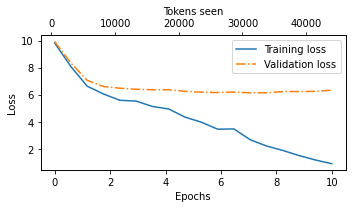

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epoches_seen, tokens_seen, train_losses, val_losses):
	fig, ax1 = plt.subplots(figsize=(5,3))
	ax1.plot(epoches_seen, train_losses, label="Training loss")
	ax1.plot(epoches_seen, val_losses, linestyle="-.", label="Validation loss")
	ax1.set_xlabel("Epochs")
	ax1.set_ylabel("Loss")
	ax1.legend(loc="upper right")	# 图例位置
	ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # 仅在 x 轴上显示整数标签

	ax2 = ax1.twiny()
	ax2.plot(tokens_seen, train_losses, alpha=0)
	ax2.set_xlabel("Tokens seen")

	fig.tight_layout()	# 调整布局
	plt.savefig("loss-plot.pdf")
	plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### 5.3 Decoding strategies to control randomness

In [27]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
	model=model,
	idx=text_to_token_ids("Every effort moves you", tokenizer),
	max_new_tokens=25,
	context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




#### 5.3.1 Temperature scaling

In [28]:
# 用 torch.multinomial(probs, num_samples=1) 在概率词表中随机抽取词
vocab = { 
	"closer": 0,
	"every": 1, 
	"effort": 2, 
	"forward": 3,
	"inches": 4,
	"moves": 5, 
	"pizza": 6,
	"toward": 7,
	"you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

# input: every effort moves you
# 假定输出结果为以下
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [29]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


In [30]:
# 依照概率用torch.multinomial进行1000次采样
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


- 用 temperature scaling 控制采样的随机性
- 将 logits 除以 temperature (temperature > 0)
- \> 1 时，采样更随机
- \<1 时，采样更确定

In [31]:
def softmax_with_temperature(logits, temperature):
	scaled_logits = logits / temperature
	return torch.softmax(scaled_logits, dim=0)

temperatures = [1, 0.1, 5]

scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SIMSUN


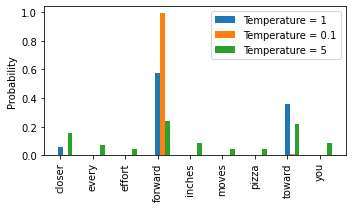

In [32]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

plt.rcParams['font.sans-serif'] = ['SIMSUN']

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
# ax.set_title("三种不同缩放系数所导致的概率分布")

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

- 当 temperature 趋近于0 时 torch.multinomial 的结果会接近 torch.argmax

In [33]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward
0 x you


In [34]:
print_sampled_tokens(scaled_probas[2])

153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


#### 5.3.2 Top-k

- 选前k个概率最大的token

- ~~Top-p~~ 前n个概率和大于p的token

In [35]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [36]:
new_logits = torch.where(
	condition=next_token_logits < top_logits[-1],	# 将小于最小选择概率的值取为-inf
	input=torch.tensor(float("-inf")),
	other=next_token_logits	# 不符合条件则不变
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [37]:
# 更高效的实现
# 不保留梯度信息 但不需要梯度
# 文本生成（采样）在训练之后 用来实际使用模型
new_logits = torch.full_like( # create tensor containing -inf values
next_token_logits, -torch.inf
)   
new_logits[top_pos] = next_token_logits[top_pos] # copy top k values into the -inf tensor

In [38]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


#### 5.3.3 Modifying the text generation function

- 用temporary scaling 和 top-k 采样 修改 generate_text_simple 为generate

In [39]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
	for _ in range(max_new_tokens):
		idx_cond = idx[:, -context_size:]
		with torch.no_grad():
			logits = model(idx_cond)
		logits = logits[:, -1, :]

		if top_k is not None:
			top_logits, _ = torch.topk(logits, top_k)
			min_val = top_logits[:, -1]
			logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(device), logits)

		if temperature > 0.0:
			logits = logits / temperature
			probs = torch.softmax(logits, dim=-1)
			idx_next = torch.multinomial(probs, num_samples=1)
		else:
			idx_next = torch.argmax(logits, dim=-1, keepdim=True)

		if idx_next == eos_id:	# 若是终止符 则退出
			break

		idx = torch.cat((idx, idx_next), dim=1)

	return idx

In [40]:
torch.manual_seed(123)
model.to(device)

token_ids = generate(
	model=model,
	idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
	max_new_tokens=15,
	context_size=GPT_CONFIG_124M["context_length"],
	top_k=25,
	temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as terr what one of the pale yellow to face that with a curious.


### 5.4 保存模型权重

In [41]:
# 保存
torch.save(model.state_dict(), "model.pth")

In [42]:
# 读取
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();	# 抑制该行代码的输出

- Adam AdamW优化器 也有参数可保存

In [43]:
torch.save({
	"model_state_dict": model.state_dict(),
	"optimizer_state_dict": optimizer.state_dict()
	},
	"model_and_optimizer.pth"
)

In [44]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
model.train();

### 5.5 读取OpenAI的模型权重

In [45]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.13.1
tqdm version: 4.62.3


In [46]:
from gpt_download import download_and_load_gpt2;

2025-07-09 12:50:53.422608: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 12:50:53.467064: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [50]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
Primary URL (https://openaipublic.blob.core.windows.net/gpt-2/models/124M/model.ckpt.data-00000-of-00001) failed. Attempting backup URL: https://f001.backblazeb2.com/file/LLMs-from-scratch/gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [51]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [52]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


- OpenAI的模型中有bias 所以需要吧qkv_bias 设置为True

In [53]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [54]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [55]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [56]:
# 生成
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn unless something interrupts your control flow. As you may observe I


In [ ]:
# Every effort moves you as far as the hand can go until the end of your turn unless something interrupts your control flow. As you may observe I